In [292]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from warnings import filterwarnings
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
import os
import matplotlib.pyplot as plt
import seaborn as sns
filterwarnings('ignore')


In [293]:
# Load data
do_sample = False
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print("train data shape", train.shape)
print("test data shape", test.shape)


train data shape (400665, 202)
test data shape (399335, 201)


In [294]:
train_input = train.drop(['id','target','B_15'],axis = 1)
test_input  = test.drop(['id','B_15'],axis = 1)

train_labels = train['target']

app_train = pd.get_dummies(train_input)
app_test = pd.get_dummies(test_input)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(app_train)
train_imputed = imp_mean.transform(app_train)
test_imputed = imp_mean.transform(app_test)

scaler = StandardScaler()
scaler.fit(train_imputed)
train_imputed = scaler.transform(train_imputed)
test_imputed = scaler.transform(test_imputed)


In [295]:

features = list(app_train.columns)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train_imputed,train_labels)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.6s finished


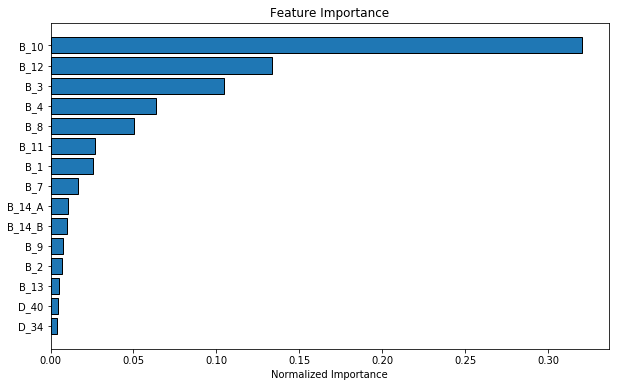

In [296]:
def plot_feature_importances(df):
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    
    return df
feature_importances_sorted = plot_feature_importances(feature_importances)

In [297]:
fe_threshold = 0.001
selected_features = feature_importances_sorted.query('importance_normalized > {}'.format(fe_threshold))['feature'].values
print(selected_features)

['B_10' 'B_12' 'B_3' 'B_4' 'B_8' 'B_11' 'B_1' 'B_7' 'B_14_A' 'B_14_B'
 'B_9' 'B_2' 'B_13' 'D_40' 'D_34' 'D_66' 'D_142' 'D_166' 'D_145' 'D_56'
 'D_138' 'D_6' 'D_13' 'D_152' 'D_116' 'D_117' 'D_121' 'D_132' 'D_26'
 'D_17' 'D_1' 'B_6_B' 'B_5_B' 'D_154' 'D_131' 'D_162' 'D_65' 'D_35' 'D_42'
 'D_49' 'D_63' 'D_149' 'D_94' 'D_128' 'D_69' 'D_3' 'D_61' 'D_28' 'D_24'
 'D_27' 'D_165' 'D_141' 'D_102' 'D_120' 'D_140' 'D_21' 'D_79' 'D_89'
 'D_123' 'D_130' 'D_103' 'D_72' 'D_37' 'D_18' 'D_95']


In [298]:
train_imputed= pd.DataFrame(train_imputed, columns = app_train.columns)
test_imputed= pd.DataFrame(test_imputed, columns= app_test.columns)
train_imputed=pd.concat([train_imputed[selected_features], train_labels])
test_imputed=test_imputed[selected_features]

In [299]:
target_column ='target'
id_column = 'id'
categorical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.object]]
numerical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
preprocess = make_column_transformer(
    (numerical_cols, make_pipeline(SimpleImputer(), StandardScaler())),
    (categorical_cols, OneHotEncoder()))
train_input = preprocess.fit_transform(train_input)
test_input = preprocess.fit_transform(test_input)
print(type(train_input))

<class 'numpy.ndarray'>


In [300]:
classifiers = {
"model_lgbm" : LGBMClassifier(n_jobs=-1,eta=0.01,max_depth=5,max_bin=512,learning_rate=0.01,num_iterations=1000),
"model_xgb" : XGBClassifier(n_jobs=-1, nthreads=-1),
"model_lr" : LogisticRegression(n_jobs=-1),
"model_gnb" : GaussianNB(),
"model_rf" : RandomForestClassifier(n_jobs=-1, random_state=42)
}

In [301]:
def get_fitted_models_and_preds(df, labels, models):
    ret =[]
    for k,v in models.items():
        pred = cross_val_predict(v, df, labels, cv=5, method="predict_proba", n_jobs=-1, verbose=20)
        model = v.fit(df, labels)
        score = roc_auc_score(labels, pred[:,1])
        ret.append({'classifier':k, 'score':score, 'preds':pred, 'model': model})
        print("model {}: {}".format(k,score))
    return ret

In [302]:
def predict_models(df, fitted_base_models):
    ret_df = pd.DataFrame()
    for fitted_base_model in fitted_base_models:
        pred = fitted_base_model['model'].predict_proba(df)
        ret_df[fitted_base_model['classifier']] = pred[:,1]
    return ret_df

In [303]:
base_models_preds_train = get_fitted_models_and_preds(train_input, train_labels, classifiers)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


model model_lgbm: 0.6347207560460116


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.4min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished


model model_xgb: 0.6320448579383714


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


model model_lr: 0.6145458666139011


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.2s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.3s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


model model_gnb: 0.5616465853649859


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.2s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.7s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


model model_rf: 0.5235734377735217


In [304]:
df_base_model_preds_train = pd.DataFrame({base_model_pred_train['classifier']:base_model_pred_train['preds'][:,1] for base_model_pred_train in base_models_preds_train})
print(df_base_model_preds_train.head())
print(df_base_model_preds_train.shape)
print(train_labels.shape)

      model_gnb  model_lgbm  model_lr  model_rf  model_xgb
0  3.214048e-03    0.006295  0.004129       0.0   0.006462
1  9.999018e-01    0.007159  0.007799       0.0   0.006753
2  6.757536e-04    0.006683  0.004405       0.0   0.006040
3  9.999703e-01    0.006561  0.008637       0.0   0.007214
4  1.955862e-12    0.001270  0.002267       0.0   0.002652
(400665, 5)
(400665,)


In [305]:
second_level_classifier_gbm = XGBClassifier(
 #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

second_level_model= second_level_classifier_gbm.fit(df_base_model_preds_train, train_labels)


In [306]:
ensemble_preds_train = second_level_model.predict_proba(df_base_model_preds_train)
print(ensemble_preds_train[:,1])
ensemble_preds_score = roc_auc_score(train_labels, ensemble_preds_train[:,1])
print(ensemble_preds_score)


[0.00197829 0.00513683 0.0077594  ... 0.02525909 0.01135582 0.00329689]
0.960146889409048


In [309]:
df_test_base_model_preds = predict_models(test_input, base_models_preds_train)
df_test_base_model_preds_col_ordered = pd.DataFrame()
for col in df_base_model_preds_train.columns:
    df_test_base_model_preds_col_ordered[col] = df_base_model_preds_train[col]
ensemble_preds_test = second_level_classifier_gbm.predict_proba(df_test_base_model_preds_col_ordered)

In [311]:
sub = pd.read_csv("data/sample_submission.csv")
print(ensemble_preds_test.shape)
print(sub.shape)

sub[target_column] = ensemble_preds_test[:,1]
sub.to_csv("results/submit_results.csv", index=False)
print('done')

(400665, 2)
(399335, 2)


ValueError: Length of values does not match length of index

In [208]:
%%bash
kaggle competitions submit -c kaggledays-sf-hackathon -f ./results/submit_results.csv -m "crawl"

Successfully submitted to KaggleDays SF Hackathon

100%|██████████| 10.7M/10.7M [00:01<00:00, 5.91MB/s]
